In [17]:
import sys
import argparse
import os
import numpy as np
from skimage.util import view_as_windows
from utilities.config_handler import get_config
from utilities.learning import split_train_validation, train_model, predict_ae_error_vectors
from utilities.detection import detect_reconstruction_anomalies_median,plot_spectogram_anomalies
from utilities.preprocessing import  add_noise,load_fft_test_data ,load_fft_train_data,  reshape_to_blocks,persist_object\
    ,load_object,persist_val_stat, load_val_stat ,get_xhdr_sample_rate
import matplotlib.pyplot as plt
from sklearn import mixture
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin_min
from scipy.stats import entropy
%matplotlib inline

In [21]:
parser = argparse.ArgumentParser()
parser.prog = 'Spectrum Anomaly Detection'
parser.description = 'Use this command parser for training or testing the anomaly detector'
parser.add_argument('-m', '--mode', help='train or test mode', choices=['train', 'test'])
parser.add_argument('-d', '--data-dir', help='I/Q recording directory')
parser.add_argument('-w', '--weights-path', help='path for trained weights')


sys.argv = "-m test -d iq_data/CELL/normal/CELL_NORM_1 -w model/baseline_clustering".split()
namespace = parser.parse_args(sys.argv)
if not namespace.data_dir and namespace.mode == 'train':
    parser.error('the -d arg must be present when mode is train')
if not namespace.weights_path and namespace.mode == 'train':
    parser.error('the -w arg must be present when mode is train')

if not namespace.data_dir and namespace.mode == 'test':
    parser.error('the -d arg must be present when mode is test')
if not namespace.weights_path and namespace.mode == 'test':
    parser.error('the -w arg must be present when mode is test')

# Hyper parameters

In [22]:
conf=get_config()
gpus = conf['gpus']
lr=conf['learning']['ae']['lr']
validation_split = conf['learning']['ae']['validation_split']
train_params = conf['learning']['ae']
rbw_set = conf['preprocessing']['ae']['rbw_set']
feature_names = conf['preprocessing']['ae']['feature_names']
train = namespace.mode == 'train'

data_dir = namespace.data_dir

atom_height = 1
fraction = 0.2
num_clusters = 1000
f_s = get_xhdr_sample_rate(data_dir)
test_window_time = 10e-6
cv_types = ['diag']

assert len(data_dir) != 0
dataset_name = str.split(data_dir, '/')[1]
recording_name = str.split(data_dir,'/')[-1]

In [23]:
def split_spectogram_to_atoms(spectogram,atom_height,stride=1):
    window_shape = (atom_height , spectogram.shape[1])
    return view_as_windows(spectogram,window_shape,step=stride).reshape(-1,*window_shape)

In [24]:
def fit_gmm(data,num_clusters,cv_types):
    lowest_bic = np.infty
    bic = []
    best_component=''
    best_cv=''
    best_gmm={}
    n_components_range = np.arange(2, num_clusters,20) # specifying maximum number of clusters
    for cv_type in cv_types:
        for n_components in n_components_range:
            # Fit a mixture of Gaussians with EM
            gmm = mixture.GaussianMixture(n_components=num_clusters, covariance_type=cv_type,verbose=2)
            gmm.fit(data)
            bic.append(gmm.bic(data))
            if bic[-1] < lowest_bic:
                lowest_bic = bic[-1]
                best_component = n_components
                best_cv = cv_type
                best_gmm = gmm
                print(best_cv)
                print(lowest_bic)
    print("best n_component {}".format(best_component))
    print("best gmm type {}".format(best_cv))
    return best_gmm

def fit_kmeans(data,num_clusters):
    k_means = KMeans(init='k-means++', n_clusters=num_clusters,n_jobs=-1,precompute_distances=True,n_init=3)
    k_means.fit(data)
    return k_means

In [25]:
def split_spectogram_by_fraction(spectogram,frac):
    return spectogram[:int(frac*len(spectogram))]

In [26]:
if train:
    for rbw in rbw_set:
        weights_dir = "_".join((dataset_name, str(rbw)))
        weights_path = os.path.join(namespace.weights_path, weights_dir)
        fft_train = load_fft_train_data(data_dir, rbw, weights_path)
        fft_train = split_spectogram_by_fraction(fft_train,fraction)
        atom_fft_train = split_spectogram_to_atoms(fft_train,atom_height)
        flatten_atom_fft_train = atom_fft_train.reshape(len(atom_fft_train),-1)
        
        k_means = fit_kmeans(flatten_atom_fft_train,num_clusters)
        (_,min_distances_train) = pairwise_distances_argmin_min(flatten_atom_fft_train,k_means.cluster_centers_,metric='euclidean')
        persist_object(k_means,os.path.join(weights_path,'k_means.pkl'))
        
else:
    for rbw in rbw_set:
        weights_dir = "_".join((dataset_name, str(rbw)))
        weights_load_path = os.path.join(namespace.weights_path, weights_dir)
        freqs_test, time_test, fft_test = load_fft_test_data(data_dir, rbw, weights_load_path)
        
        fft_test = split_spectogram_by_fraction(fft_test,fraction)
        atom_fft_test = split_spectogram_to_atoms(fft_test,atom_height)
        flatten_atom_fft_test = atom_fft_test.reshape(len(atom_fft_test),-1)
        k_means = load_object(os.path.join(weights_load_path,'k_means.pkl'))
        window_shape = (atom_height , atom_fft_test.shape[1] // atom_height)
        score_spectogram = np.ones_like(atom_fft_test)

In [27]:
(_,min_distances_test) = pairwise_distances_argmin_min(flatten_atom_fft_test,k_means.cluster_centers_,metric='euclidean')
(_,min_distances_train) = pairwise_distances_argmin_min(flatten_atom_fft_train,k_means.cluster_centers_,metric='euclidean')

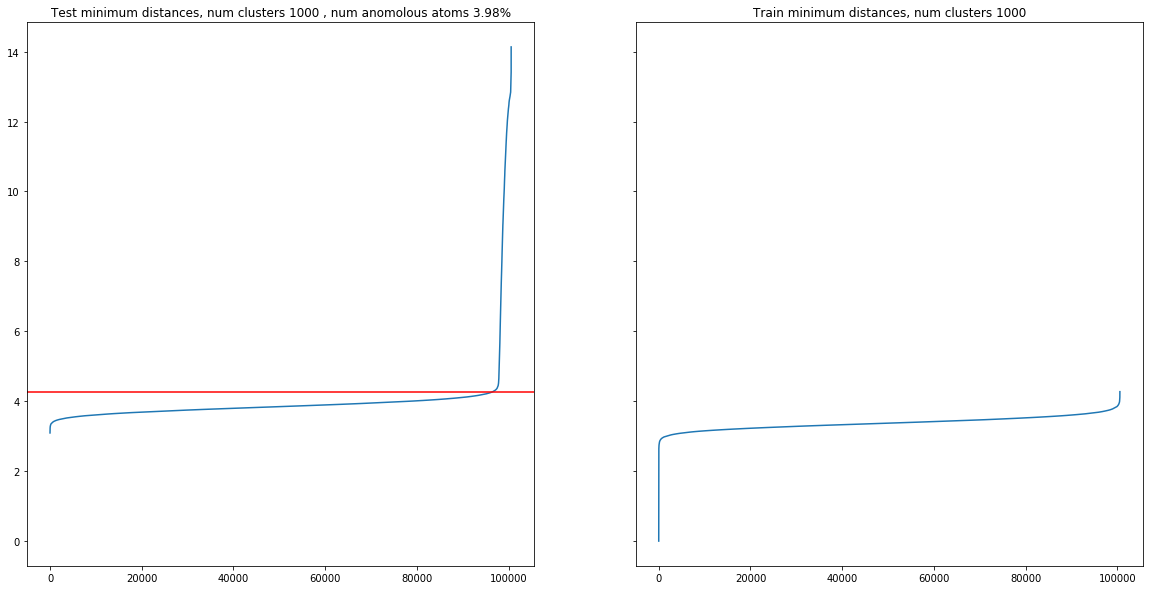

In [57]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(20,10))
max_train_distance = np.max(min_distances_train)
percent_anomalies = (len(np.where(min_distances_test > np.max(min_distances_train))[0])/len(min_distances_test)) * 100
ax1.plot(np.sort(min_distances_test))
ax1.axhline(max_train_distance,color='r')
ax1.set_title('Test minimum distances, num clusters {0:d} , num anomolous atoms {1:.2f}%'.format(num_clusters,percent_anomalies))
ax2.plot(np.sort(min_distances_train))
ax2.set_title("Train minimum distances, num clusters {}".format(num_clusters))

plot_path = os.path.join(namespace.data_dir ,'cluster_distances.png')
plt.savefig(plot_path)
plt.show()

In [52]:
percent_anomalies

3.9825384829561274